In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import datasets,transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch import cuda

In [4]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3,1)
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216,128)
        self.fc2 = nn.Linear(128,10)
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x,dim = 1)
        return output

In [10]:
def train(model,train_loader,optimizer,epoch):
    model.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch,batch_idx * len(data),len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [11]:
def test(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data,target in test_loader:
            data,target = data.to(device),target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output,target,reduction='sum').item()
            pred = output.argmax(dim = 1, keepdim= True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss : {:.4f}, Accuracy : {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',train=True, download= True,
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,),(0.3081,))])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',train=False,
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,),(0.3081,))
    ])),
    batch_size=1000,shuffle=True)
model = Net()
model.to(device)
optimizer = optim.Adadelta(model.parameters(),lr = 1.0)
# scheduler = StepLR(optimizer,step_size=1,gamma=0.7)
for i in range(1):
    train(model,train_loader,optimizer,1)
    test(model,test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315162
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.964161


KeyboardInterrupt: 

In [179]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    print(image.shape)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [180]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

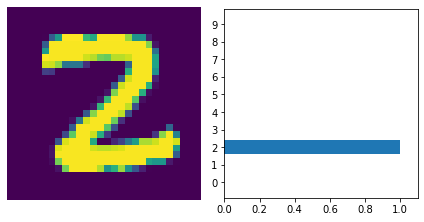

In [181]:
model.eval()
images,labels = next(iter(train_loader))
with torch.no_grad():
    logits = model.forward(images[:1])
pred = logits.argmax(dim = 1, keepdim= True)
view_classify(images,torch.exp(logits))